# Genre analysis

This notebook will analyze the evolution of genres in movies over the years and over the countries.

In [1]:
# Modules to import
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

In [2]:
# Paths to add
paths = ['../data','../scripts','../utils']
for path in paths:
    sys.path.append(path)
    
# Data loader
from dataLoader import loadDataframe

# Load data
path_to_directory = '../../data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\arnau\OneDrive\Documents\Scolarité EPFL\ADA\ada-2024-project-teamcsx24\src\data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


Modification of country names to match with geopandas name

In [3]:
df_movies.head(2)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],[/m/02h40lc],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]"


In [4]:
from generalUtils import transformCountryNameGpd

In [5]:
df_movies['countries'] = df_movies['countries_freebase_id'].apply(transformCountryNameGpd)

Preparation of the dataset for the analysis (explode genres and countries)

In [6]:
df_genres_countries_exploded = df_movies.explode('genres').explode('countries')
df_genres_countries_exploded.head(3)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."


In [7]:
# Check for missing values
df_genres_countries_exploded.isna().sum()

wiki_id                       0
freebase_id                   0
original_title                0
release_date              12530
revenue                  240221
runtime                   41850
languages                     0
countries                 13759
genres                     2361
countries_freebase_id         0
languages_freebase_id         0
genres_freebase_id            0
dtype: int64

In [8]:
# Print number of movies
nb_movies = df_genres_countries_exploded['wiki_id'].nunique()
print(f'Total number of movies: {nb_movies}')

df_genres_countries_exploded.dropna(subset=['countries','release_date','genres'], inplace=True)

nb_movies_after_dropna = df_genres_countries_exploded['wiki_id'].nunique()
print(f'Total number of movies with countries, release date and genres: {nb_movies_after_dropna}')

print(f'Pourcentage of dropped movies: {100*(1-nb_movies_after_dropna/nb_movies):.2f}%')

Total number of movies: 81741
Total number of movies with countries, release date and genres: 68144
Pourcentage of dropped movies: 16.63%


Only 84% of the movies have genre, country and release date information. It represents 68144 movies, which seems to be enough for the analysis.

In [9]:
from generalUtils import attachWorldRegion
df_genres_countries_exploded['region'] = df_genres_countries_exploded['countries'].apply(attachWorldRegion)

In [10]:
print("Number of unique genres: ", df_genres_countries_exploded['genres'].nunique())
print(df_genres_countries_exploded['genres'].unique())

Number of unique genres:  362
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom Drama'
 'Culture & Society' 'Biography' 'Documentary' 'Christmas

There are 362 different genres in the dataset. The most common genres are Drama, Comedy and Romance. To begin with, we will analyze the evolution of the most common genres over years and countries.

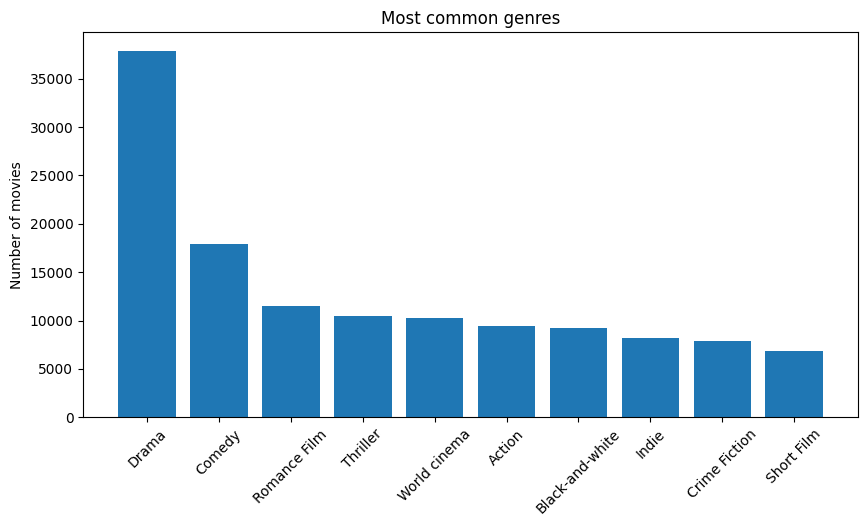

In [11]:
most_common_genres = df_genres_countries_exploded['genres'].value_counts().head(10)

plt.figure(figsize=(10,5))
plt.bar(most_common_genres.index, most_common_genres.values)
plt.title('Most common genres')
plt.ylabel('Number of movies')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Convert release date to year
df_genres_countries_exploded['year'] = pd.to_datetime(df_genres_countries_exploded['release_date']).dt.year

### 1. Analysis per world region

In [13]:
# Unique regions
df_genres_countries_exploded['region'].unique()

array(['North America', 'Europe', 'Africa', 'South America',
       'East and Southeast Asia', 'Middle East',
       'Eastern Europe and Central Asia', 'South Asia', 'Oceania'],
      dtype=object)

In [23]:
df = df_genres_countries_exploded.groupby(['region','year','genres']).size().reset_index(name='count')
df.head(5)

,region,year,genres,count
0,Africa,1916,Drama,1
1,Africa,1916,Historical fiction,1
2,Africa,1916,Silent film,1
3,Africa,1932,Black-and-white,1
4,Africa,1932,Drama,1


In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [26]:
# Initialize Dash app
app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id="region-selector",
        options=[{"label": c, "value": c} for c in df["region"].unique()],
        value=[df["region"].unique()[0]],  # Default to the first region
        multi=True  # Enable multi-selection
    ),
    dcc.Graph(id="genre-proportion")
])

@app.callback(
    Output("genre-proportion", "figure"),
    [Input("region-selector", "value")]
)
def update_genre_proportion(selected_regions):
    # Create a subplot layout for multiple pie charts
    rows = 1  # Number of rows
    cols = len(selected_regions)  # Number of columns (based on selected regions)
    fig = make_subplots(
        rows=1, cols=cols,
        subplot_titles=selected_regions,
        specs=[[{"type": "domain"}] * cols]
    )
    
    # Add a pie chart for each selected region
    for idx, region in enumerate(selected_regions):
        region_data = df[df["region"] == region]
        top_genres = (
            region_data.groupby("genres")["count"]
            .sum()
            .nlargest(5)
            .reset_index()
        )
        fig.add_trace(
            go.Pie(
                labels=top_genres["genres"],
                values=top_genres["count"],
                name=region
            ),
            row=1, col=idx + 1
        )
    
    # Update layout to make it visually appealing
    fig.update_layout(
        title_text="Top 5 Genres for Selected Regions",
        title_x=0.5,  # Center the title
        height=500,
        showlegend=False  # Avoid repeated legends for each pie chart
    )
    
    return fig

if __name__ == "__main__":
    app.run_server(debug=True)

### 2. Analysis per country

In [17]:
df = df_genres_countries_exploded.groupby(['countries', 'year', 'genres']).size().reset_index(name='count')
df.head(5)

,countries,year,genres,count
0,Afghanistan,1975,Action/Adventure,1
1,Afghanistan,1975,Bollywood,1
2,Afghanistan,1975,Thriller,1
3,Afghanistan,1975,World cinema,1
4,Afghanistan,1992,Action/Adventure,1


In [47]:
# Initialize Dash app
app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id="country-selector",
        options=[{"label": c, "value": c} for c in df["countries"].unique()],
        value=df["countries"].unique()[0]
    ),
    dcc.Graph(id="genre-proportion")
])

@app.callback(
    Output("genre-proportion", "figure"),
    [Input("country-selector", "value")]
)
def update_genre_proportion(selected_country):
    country_data = df[df["countries"] == selected_country]
    top_genres = (
        country_data.groupby("genres")["count"]
        .sum()
        .nlargest(5)
        .reset_index()
    )
    fig = px.pie(
        top_genres, 
        names="genres", 
        values="count", 
        title=f"5 major genres proportion in {selected_country}"
    )
    return fig

if __name__ == "__main__":
    app.run_server(debug=True)

In [43]:
app1 = Dash(__name__)

# Layout for multi-country and genre trends
app1.layout = html.Div([
    html.H1("Trends by Countries and Genres"),
    html.Label("Select Countries:"),
    dcc.Dropdown(
        id='countries-multi-dropdown',
        options=[{'label': country, 'value': country} for country in df['countries'].unique()],
        value=[df['countries'].unique()[0]],
        multi=True
    ),
    html.Label("Select Genres:"),
    dcc.Dropdown(
        id='genres-multi-dropdown',
        options=[{'label': genre, 'value': genre} for genre in df['genres'].unique()],
        value=[df['genres'].unique()[0]],
        multi=True
    ),
    dcc.Graph(id='multi-trends-plot')
])

# Callback for multi-country and genre trends
@app1.callback(
    Output('multi-trends-plot', 'figure'),
    [Input('countries-multi-dropdown', 'value'),
     Input('genres-multi-dropdown', 'value')]
)
def update_multi_trends_plot(selected_countries, selected_genres):
    filtered_df = df[(df['countries'].isin(selected_countries)) & (df['genres'].isin(selected_genres))]
    trends = filtered_df.groupby(['year', 'genres', 'countries'])['count'].sum().reset_index()
    fig = px.line(trends, x='year', y='count', color='genres', facet_col='countries',
                  title="Trends Across Countries and Genres",
                  labels={'count': 'Number of Films', 'year': 'Year'})
    return fig

if __name__ == "__main__":
    app1.run_server(debug=True)

In [46]:
# Layout for map
app.layout = html.Div([
    html.H1("Film Production Map by Genre"),
    html.Label("Select a Genre:"),
    dcc.Dropdown(
        id='map-genre-dropdown',
        options=[{'label': genre, 'value': genre} for genre in df['genres'].unique()],
        value=df['genres'].unique()[0]
    ),
    dcc.Graph(id='genre-map-plot')
])

# Callback for map
@app.callback(
    Output('genre-map-plot', 'figure'),
    Input('map-genre-dropdown', 'value')
)
def update_genre_map_plot(selected_genre):
    filtered_df = df[df['genres'] == selected_genre]
    trends = filtered_df.groupby(['year', 'countries'])['count'].sum().reset_index()
    fig = px.choropleth(trends, locations='countries', locationmode='country names',
                        color='count', animation_frame='year',
                        title=f"Film Production Map for {selected_genre}",
                        labels={'count': 'Number of Films'})
    return fig

if __name__ == "__main__":
    app.run_server(debug=True)

AssertionError: The setup method 'errorhandler' can no longer be called on the application. It has already handled its first request, any changes will not be applied consistently.
Make sure all imports, decorators, functions, etc. needed to set up the application are done before running it.